#CS741: Assignment 1: Introduction to inference in Graphical Models
## Dr. Hennie de Villiers - Computer Science - Stellenbosch University

## Name: YOUR NAME
## Student Number: YOUR STUDENT NUMBER


Note: Parts of the assignment were adapted from Prof. Johan du Preez at Electronic Engineering.

## Theano Warmup

This assignment is, primarily, about getting you started with Theano for the various machine learning tasks we will be considering. We will also apply the Theano concepts learnt to perform some interesting inference tasks. The first two sections will take you on a small tour of Theano, and implement some of the functions you will need later.

The first you have to do, is to get a hold of Theano [over here](http://deeplearning.net/software/theano/install.html).

If you need a decent Python distribution, try [Anaconda](http://continuum.io/downloads).

You will also need: `graphviz` (a program for visualizing graphs), `pydot` (a Python interface to Graphviz).

Once Theano is ready, you should be able to continue with importing Theano, Numpy and Matplotlib as follows:

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import theano
import theano.tensor as T

Happy times, if you didn't get an error :) If you haven't changed any environment variables, Theano is probably going to execute code on the CPU, but this is better for the moment.

Okay, the first thing you have to master, it defining simple variables and functions in Theano. In Theano, we built functions by manipulating *symbolic variables*. For example, let's make a new variable $X$.

In [2]:
x = T.scalar("X")

Boom. You now have a symbolic scalar value. Feels good doesn't it? 

Incidently, `T.scalar` produces a symbolic floating point number of type `theano.config.floatX`, which is the preferred floating point number format for a given execution backend. On the CPU, this is usually a 64-bit float, on the GPU it is usually a 32-bit float. It is important to try to use this type in your code, because often Theano will only use the GPU if it your operations are on this kind of data.

Performing operations on symbolic operations is extremely simple. 

In [3]:
print x
y = x*x
print y

X
Elemwise{mul,no_inplace}.0


You can see above that the first `print` simply displays the name of the symbolic variable. The second `print` is displaying the name of the symbolic expression (which is the name of the top-most operation in the expression, an non-inplace multiplication).

We can't really do anything with the symbolic variables until are able to give values to them, and get the results of expressions based on them. We could use the `eval` method of a given expression, which we give a dictionary of mappings between symbolic variables and their values.

In [4]:
print y.eval({x : 5})

25.0


Sadly, this

`print x.eval({y : 36})`

won't work. At least, not yet.

We can see how Theano has built up a symbolic expression by using

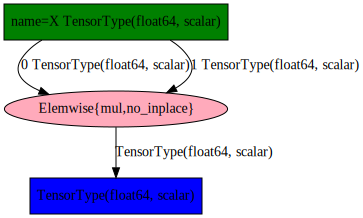

In [5]:
import pydot
from IPython.display import SVG
SVG(theano.printing.pydotprint(y, format="svg", return_image=True))


You can find out more about how Theano represents expressions [here](http://deeplearning.net/software/theano/tutorial/symbolic_graphs.html). You should also make sure to familiarise yourself with all the [debugging functionality](http://deeplearning.net/software/theano/tutorial/printing_drawing.html) that Theano provides, you might need it :)

We can make a more permanent Theano function to perform this operation using

In [6]:
my_func = theano.function([x], y)

print my_func(5)

25.0


## Implementing CPD inference in Theano
We are now going to learn more about multidimensional arrays (tensors) in Theano by implementing some basic inference tasks. Consider representing the conditional probability $P(A|B,E)$ from the "Alarm" problem from Chapter 3. The Numpy array representing this is given by:

In [7]:
p_a_given_be = np.zeros((2,2,2),dtype=theano.config.floatX)
p_a_given_be[1,0,0] = 0.0001 # P(A=1|B=0,E=0)
p_a_given_be[1,0,1] = 0.99 # P(A=1|B=0,E=0)
p_a_given_be[1,1,0] = 0.99 # P(A=1|B=0,E=0)
p_a_given_be[1,1,1] = 0.9999 # P(A=1|B=0,E=0)
p_a_given_be[0,:,:] = 1 - p_a_given_be[1,:,:]

Similarly, $P(R|E)$, $P(E)$ and $P(B)$ are given by

In [8]:
p_r_given_e = np.zeros((2,2),dtype=theano.config.floatX)
p_r_given_e[1,0] = 0.0
p_r_given_e[1,1] = 1.0
p_r_given_e[0,:] = 1 - p_r_given_e[1,:]

p_e = np.zeros((2,),dtype=theano.config.floatX)
p_e[1] = 0.000001
p_e[0] = 1 - p_e[1]

p_b = np.zeros((2,),dtype=theano.config.floatX)
p_b[1] = 0.01
p_b[0] = 1 - p_b[1]

We can make Theano aware of these factors by creating shared variables

In [9]:
alarm_factor = theano.shared(p_a_given_be)
radio_factor = theano.shared(p_r_given_e)
burglar_factor = theano.shared(p_b)
earthquake_factor = theano.shared(p_e)

Now, we can define state variables for each of the alarm problem's variables. The are 64-bit integer scalars, so we use the `T.lscalar` constructor (`l` for `long`)

In [10]:
alarm = T.lscalar("A")
burglar = T.lscalar("B")
earthquake = T.lscalar("E")
radio = T.lscalar("R")

and we can define the joint probability distribution as

In [11]:
joint_alarm = earthquake_factor[earthquake] * burglar_factor[burglar] * radio_factor[radio, earthquake] * alarm_factor[alarm, burglar, earthquake]

Now we can ask the joint distribution of the alarm problem to evaluate for a given assignment of variables

In [12]:
print joint_alarm.eval({alarm:1,burglar:1,earthquake:0,radio:0})
print joint_alarm.eval({alarm:1,burglar:1,earthquake:1,radio:1})
print joint_alarm.eval({alarm:1,burglar:0,earthquake:1,radio:1})

0.0098999901
9.999e-09
9.801e-07


A more convenient way to evaluate the joint can be defined

In [13]:
joint_func = theano.function([alarm,burglar,earthquake,radio],joint_alarm)
print joint_func(1,1,0,0)

0.0098999901


We can have a look at what the computational graph looks like

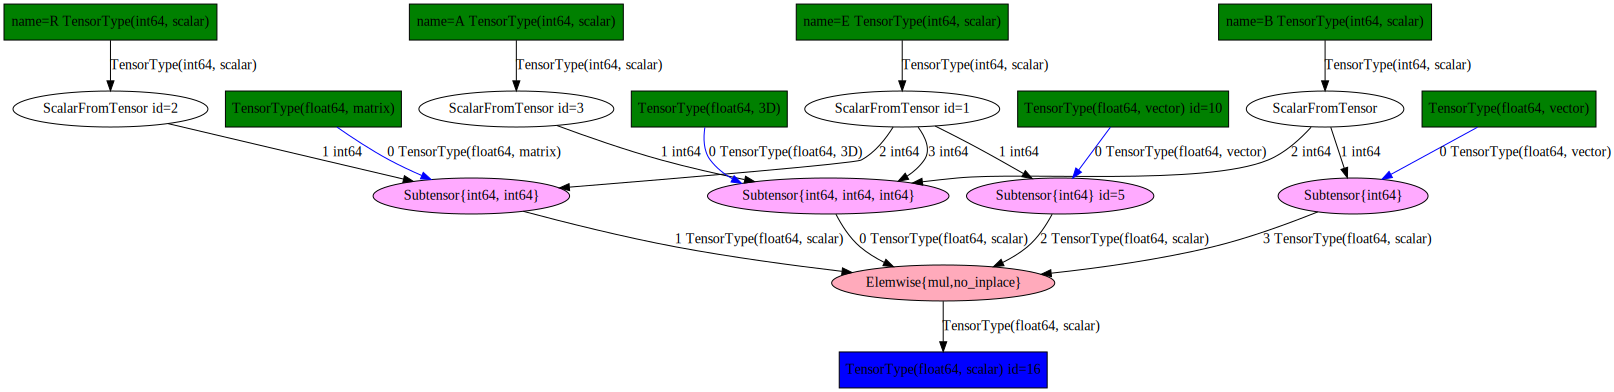

In [14]:
SVG(theano.printing.pydotprint(joint_func, format="svg", return_image=True))


In [15]:
joint_func_given_r = theano.function([alarm,burglar,earthquake],joint_alarm,givens={radio:1})
print joint_func_given_r(1,1,1)

9.999e-09


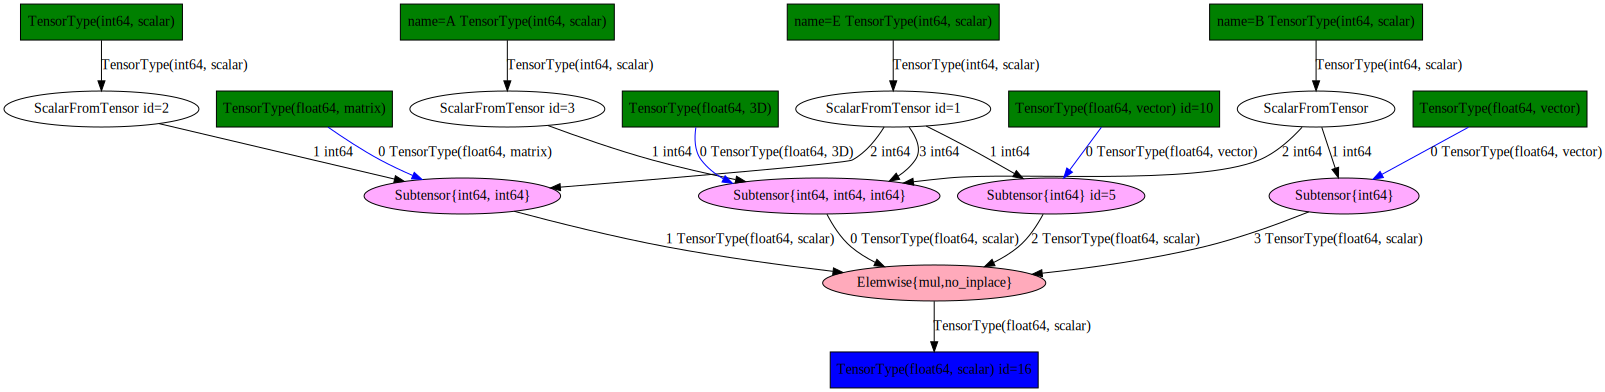

In [16]:
SVG(theano.printing.pydotprint(joint_func_given_r, format="svg", return_image=True))

## Making it more efficient

Now, this is certainly a correct way of implementing the joint distribution, but it is not very useful for performing inference. Or, at least, inference using this will be very inefficient. We need another way of handling, combining, marginalizing and conditioning potentials.

Think a bit about how inference, in general, happens. We:
* Condition variables which are given,
* take the product of all conditioned potentials, and
* marginalize over the variables we are not interested in.

To perform these operations, we need the following information:
* The CPD of each factor as an array
* The variables bound to each dimension of each CPD
* The list of conditioned variables and their corresponding values
* The order of variables within the final product potential
* The list of variables we wish to marginalize over

For example, in the burglar network, if we want to condition $R=1, A=1$, and want to know the marginal for $B$, we can represent all the needed data as follows:

In [17]:
cpds = [alarm_factor, radio_factor, burglar_factor, earthquake_factor]
bound_vars = [(alarm, burglar, earthquake), (radio, earthquake), (burglar,), (earthquake,)]
conditioned_vars = set([radio, alarm])
final_vars = [burglar]
marginalize = [radio, earthquake]

Now, to perform the operation, we need to first condition all the CPDs. Each CPD can be conditioned using:

In [18]:
def cpd_condition(cpd, cpd_vars, conditioning_vars):
    cpd_slice = []
    sliced_cpd_vars = []
    for var in cpd_vars:
        if (var in conditioning_vars):
            cpd_slice.append(var) # Use the variable to condition this dimension
        else:
            cpd_slice.append(slice(None,None)) # Slice over the whole of the dimension as in A[:]
            sliced_cpd_vars.append(var)
    cpd_slice = tuple(cpd_slice)
    return cpd[cpd_slice], tuple(sliced_cpd_vars)

cond, cond_vars = cpd_condition(cpds[0], bound_vars[0], conditioned_vars)
print cond_vars
print cond
print cond.eval({alarm:0})
print cond.eval({alarm:1})

(B, E)
Subtensor{int64, ::, ::}.0
[[  9.99900000e-01   1.00000000e-02]
 [  1.00000000e-02   1.00000000e-04]]
[[  1.00000000e-04   9.90000000e-01]
 [  9.90000000e-01   9.99900000e-01]]


We need to be able to reorder a CPD's variables to match a final order, inserting dimensions where a variable is missing. Note that `'x'` means that a given dimension has size 1 and is broadcastable (see Theano and Numpy documentation on broadcasting). 

In [19]:
def cpd_reorder(cpd, current_var_order, final_var_order):
    ordering = []
    for v in final_var_order:
        try:
            idx = current_var_order.index(v)
            ordering.append(idx)
        except ValueError:
            ordering.append("x")
    return cpd.dimshuffle(ordering)

reordered = cpd_reorder(cpds[0], bound_vars[0], [alarm, radio, earthquake, burglar])
print reordered
print reordered.eval()

DimShuffle{0,x,2,1}.0
[[[[  9.99900000e-01   1.00000000e-02]
   [  1.00000000e-02   1.00000000e-04]]]


 [[[  1.00000000e-04   9.90000000e-01]
   [  9.90000000e-01   9.99900000e-01]]]]


Now we are ready to form a product of potentials, given a list of CPDs, their bound variables, and a final variable order.

In [20]:
import operator

def cpd_product(cpds, cpd_bound_vars, final_var_order):
    reordered = [cpd_reorder(cpd, bound, final_var_order) for cpd, bound in zip(cpds, cpd_bound_vars)]
    return reduce(operator.mul, reordered)

joint_cpd = cpd_product(cpds, bound_vars, [alarm, radio, earthquake, burglar])
joint_func = theano.function([alarm,burglar,earthquake,radio],joint_cpd[alarm, radio, earthquake, burglar])
print joint_func(1,1,0,0)

0.0098999901


This matches our earlier result, but look at how different the computation graph looks.

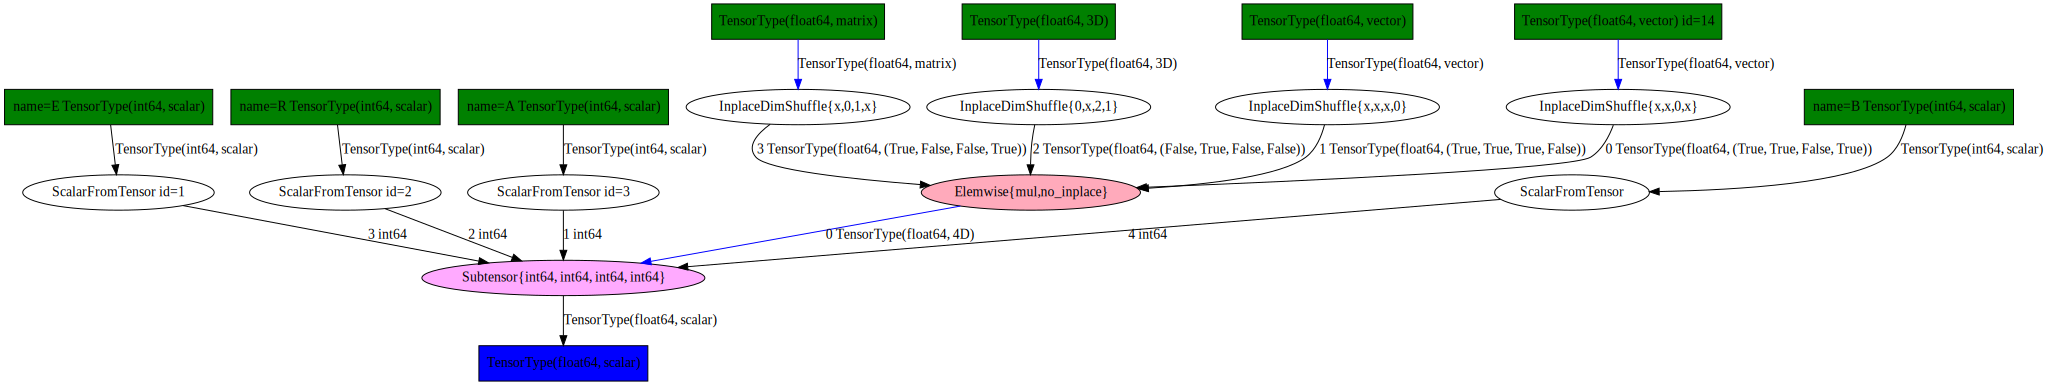

In [21]:
SVG(theano.printing.pydotprint(joint_func, format="svg", return_image=True))

You can see that, in this case, the joint CPD is calculated first, then an indexing operation is performed. Previously, each individual CPD was indexed first, followed by a multiplication. Now, this version is actually less efficient, because the function only calculates a single item from the CPD. But, we start winning when we use this representation to *marginalize* over the new CPD. We can do this as follows:

In [22]:
def cpd_marginalize(cpd, bound_variables, marginalize_out):
    axes_to_sum = [bound_variables.index(v) for v in marginalize_out]
    return T.sum(cpd,axis=axes_to_sum)

marg = cpd_marginalize(joint_cpd, [alarm, radio, earthquake, burglar], [alarm,radio,earthquake])
print marg.eval()

[ 0.99  0.01]


Note that the above returned the prior over Burglar, which is what we would expect if we marginalize out the all the other variables. Look at the following graph of the computation

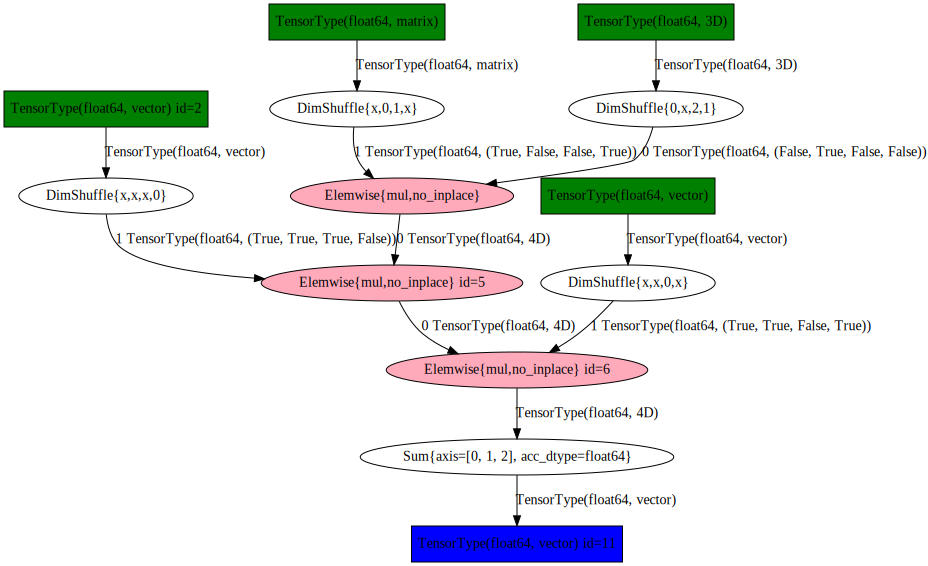

In [23]:
SVG(theano.printing.pydotprint(marg, format="svg", return_image=True))

can you see that these are all tensor operations? This is a whole lot more efficient than dealing with individual indices.

## Question 1: An Automated Party Animal

Use the methods `cpd_condition`, `cpd_product` and `cpd_marginalize` to answer Exercise 3.1. in the textbook. 

First, write a method `infer`, which will take a list of CPDs, a list of the bound variables of each CPD, a list of conditioning variables, and a list of final variables. The function must return a symbolic variable which is are the marginal probabilities given the conditioning variables, ordered as in the final variables list. An error must be raised if a variable in conditioning_vars is in final_vars. Note that the variables being marginalized out are implicit, in that the union of all variables in cpd_var_list, taking away the conditioning_vars, taking away the final_vars, are the variables over which marginalization takes place. Remember that you have to normalize the resulting array, as it is *not* a conditional distribution, it is a joint distribution which has had some of its variables set to constant values.


In [24]:
def infer(cpds, cpd_vars, conditioning_vars, final_vars):
    # INSERT CODE HERE
    return None
 

If your code is working, you should be able to run the following (based on the Burglar network variables). The answer should be $p(B=1|R=1,A=1)\approx 0.01$

In [25]:
a = infer(cpds, bound_vars, [radio, alarm], [burglar])
print a.eval({radio:1,alarm:1})[1]
SVG(theano.printing.pydotprint(a, format="svg", return_image=True))

AttributeError: 'NoneType' object has no attribute 'eval'

Write the script to solve the Party Animal question $p(Party=1|Headache=1,Angry=1)$ in the block below:

In [ ]:
# Insert code here

Plot the computation graph corresponding to your calculation below:

In [ ]:
# Insert code here

What is the probability that Bob went to a party if we don't know whether or not he has a headache?

In [ ]:
# Insert code

What is the probability that Bob went to a party if we know he does not have a headache?

In [ ]:
# Insert code

Discuss the phenomenon you observe in the previous questions.

Add your explanation here ...

## Question 2: The Monty Hall Problem

For this one we are going to consider the well-known Monty-Hall problem.   Lets first state the original
problem:  In a TV game-show a participant must choose between one of three doors.  Behind one of the
doors there is an expensive car, the other two conceals somewhat smelly goats.  The participant indicates
a certain door after which the game-show host (Monty Hall) reveals a goat behind another door.  You can
assume that the host will never at this stage open the initial choice of the participant or the door with the car.
Except for this, he has no preference for any specific door.  The participant now may reconsider his choice.
Under the assumption that he actually wants to win the car, should he stick with his original choice or should
he change to the other remaining door?

Model the above situation with a BN. Use three random variables:
- $I$ is the initial choice of the participant – it takes on values $1$, $2$ or $3$ depending on his door of
choice. The corresponding factor is $p(I)$.
- $C$ is where the car is – once again it takes on values $1$, $2$ or $3$ depending on where the car actually is. The corresponding factor is $p(C)$.
- $M$ is the door that Monty opens – once again it takes on values $1$, $2$ or $3$ depending on where the car actually is. The corresponding factor is $p(M|I,C)$. This is the tricky one to set up, carefully include all the considerations that Monty have to keep in mind when doing so.

Write your expressions for the above probability distributions in the box below. Motivate your answers.


EXPRESSIONS

In [ ]:
# Add your code for setting up the factors in Python


With the above factors in place it is easy to investigate various scenarios. Set $I$ to one of its allowed values, while leaving the other variables unobserved. Does this change the marginal for $C$? What is your conclusion about the dependence (or not) of $C$ on $I$ when $M$ is unobserved? 

In [ ]:
# Insert code

ADD DISCUSSION

Set $M$ to one of the values it can take on, while leaving the other variables unobserved.  Find the marginal for $C$. Now, with $M$ still on the value you choose, set $I$ to one of the two remaining values it can legally take on. Does this change the marginal for $C$?

In [ ]:
# Insert code

ADD DISCUSSION

Do the above in the opposite direction by setting a value for $C$ and observing what it tells us about the distribution of $I$, for the cases where $M$ is observed vs unobserved.

In [ ]:
# Insert code

ADD DISCUSSION

Let’s make things slightly more complex.  The game remains more or less as it was, but we are now
being prevented from observing $M$ directly.  Instead we get to observe a variable $D$ that depends on $M$.  Define the factor $p(D|M)$ such that we have a 50% chance that $D$ will report the correct value of $M$, and 25% chances that it will (erroneously) report one of the other two values for $M$.  Repeat the above, but now with $D$ observed/unobserved instead of $M$ (which now is never being observed directly). Conclusions?

In [ ]:
# Insert code

ADD DISCUSSION

Can you specify other equivalent networks by reversing the direction of some of the arrows?

ADD DISCUSSION

What happens to $C$ when you set the observed value of $D$ to be the same as $I$?  What is the sense behind this?

In [ ]:
conditioning_vars = [distrusted, initial]
final_vars = [car]
marginal = infer(distrusted_monty_hall_factors, distrusted_monty_hall_vars, conditioning_vars, final_vars)
print marginal.eval({distrusted:0, initial:0})

# Monty Hall would never open the same door as the initial choice, so the distrusted source must be incorrect. This means Monty Hall opened one of the other two doors (equal probability). Without us knowing, the probability for where the car is remains uniform.

ADD DISCUSSION

## Question 3: Markov Random Fields - Hamming Codes

### Background:
The Hamming $(7,4)$ code extends a 4 bit input sequence with a further 3 parity check bits to result in a 7 bit sequence to transmit. This provides redundancy that allows automatic correction of any one wrongly received bit. Figure 1 describes the coding stage of a Hamming $(7,4)$ code. 

![Encoder](encode.png)

The first four bits $b_1 \dots b_4$ represents the actual information we want to transmit. $\phi_{c_1} \dots \phi_{c_3}$ are the (even) parity checkers. Bits $b_5 \dots b_7$ are check bits to allow error correction – for a given $b_1\dots b_4$ we choose them to result in an even total parity for all the bits connected to a common $\phi_{c_i}$. For example, inputs $0111$ are transmitted as $0111010$. As an aside, note that if we should implement $\phi_{c_i}$, as potentials as we do for the decoding stage below, we can also unambiguously obtain $b_5 \dots b_7$ by finding its joint distribution given the observed $b_1 \dots b_4$.

![Decoder](decode.png)

Figure 2 is a factor graph describing the decoding process.  The sequence $r_1 \dots r_7$ describes the received
bits/signal values.  The variables $b_1 \dots b_7$ are the decoded binary bit sequence.  We can consider two cases:

- Hard decision: $r_1 \dots r_7$ are already binarised:  In this case the factors/potentials $\phi_{r_i}$ simply describe how likely it is that the received $r_i$ matches the transmitted $b_i$, i.e.  a discrete table giving
potentials for the four allocations of the variables $(r_i; b_i)$.
- Soft decision: $r_1 \dots r_7$ are the actual continuous pre-binarised received values:  In this case the
factors/potentials $\phi_{r_i}$ can be two (continuous) Gaussian pdfs for $r_i$ conditioned on whether the
transmitted value ($b_i$) was a zero or one.  The Gaussian means can be 0 and 1, while the standard
deviation for both cases can be set at 0.25.

The parity check factors/potentials $\phi_{c_i}$ takes on values zero or one based on whether its four inputs has
uneven or even parity.

*The transmitted data:* Use the coding stage to determine the 7-bit transmitted sequence for any given 4-bit
input sequence.

In [ ]:
# Insert code, as well as code to demonstrate your inference is working for all input cases.

*Hard decision decoding:* Form the received sequence $r_1 \dots r_7$ by either retaining or changing the transmitted bits according to the distribution specified by $\phi_{r_i}$. Then apply this observed
bit sequence to the factor graph of Figure 2 and calculate the joint for $b_1 \dots b_7$. The maximal value of this joint gives the optimal decoded sequence. You should be able to verify that up to one bit error in $r_i$ can be corrected by this network.

In [ ]:
# Insert code, as well as code to demonstrate your inference is working, analyzing for the rate of correct corrections 
# given number of errors in the received bits.

*Soft decision decoding:* Determine the received sequence $r_1 \dots r_7$ by adding zero mean noise to the transmitted sequence. Theoretically the standard deviation specified in $r_i$ governs the spread of the noise,
but you may also want to explicitly manipulate the values of the received sequence.  A simple direct
system will (sub-optimally) classify these $r_i$ according to whether it is closer to zero or one. Apply these $r_i$ observations to the system of Figure 2 and once again find the joint for $b_1 \dots b_7$. Once
again the maximal value of this joint gives the optimal decoded sequence.  Verify that this soft decision version is at least as accurate as the hard decision version and, dependent on the severity of the
deviations in $r_i$, can in some cases correct even more than 1 erroneous bit.

When implementing the soft decision decoder, you will soon discover that $r_i$ now is our first encounter with  a  potential  that  also  includes  continuous  variables  and  therefore  does  not  fit  the  mold  of  the potentials you used so far. The easiest (and recommended) fix avoids solving the handling of continuous variables.   Conceptually each $r_i$ is a function of both the discrete $b_i$ and the continuous $r_i$.  After observing $r_i$ this joint distribution reduces to being a potential function/distribution of $b_i$ only (which naturally
fits in with the other discrete factors in the system).  The probabilities in this distribution varies
continuously with the observed value of $r_i$, in contrast with the hard decision case where these
probabilities remain fixed. NOTE: This approach allows a discrete PGM to be used in many situations also involving continuous quantities.  Quite often one also makes use of machine learning techniques (such as logistic regression) to reduce these continuous quantities to the probabilities of discrete events.

Implement the decoding system using Theano and based on the observed $r_1 \dots r_7$, find the joint distribution of the decoded $b_1 \dots b_7$. Use this to determine the most likely decoding, and compare with the original transmitted sequence.

In [ ]:
# Insert code, as well as code to demonstrate your inference is working for various cases, 
# analyzing for the rate of correct corrections given the original bits, and their noisy received versions and
# the number of errors if we were to hard classify the bits individually using a threshold b_n>=0.5